In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

### Leitura a tratamento da base de dados

In [3]:
df = pd.read_csv(r"Geolocalização Dataset - Asset.csv", sep=",")
for col in df.columns:
    df[col] = df[col].str.replace(',', '.').astype(float)
display(df)

,latitude,longitude,price
0,-21.59136,-51.06669,52.47
1,-21.28535,-49.65497,37.03
2,-22.02590,-47.06702,71.50
3,-21.91623,-46.68666,88.27
4,-22.47639,-46.63278,36.16
...,...,...,...
648,-21.18019,-48.65482,80.53
649,-20.19354,-50.47940,82.64
650,-23.54667,-47.43778,81.67
651,-20.48010,-50.01266,17.69


In [4]:
print(df.isnull().sum())

latitude     0
longitude    0
price        0
dtype: int64


### Método do cotovelo para definir a quantidade de CDs ideal

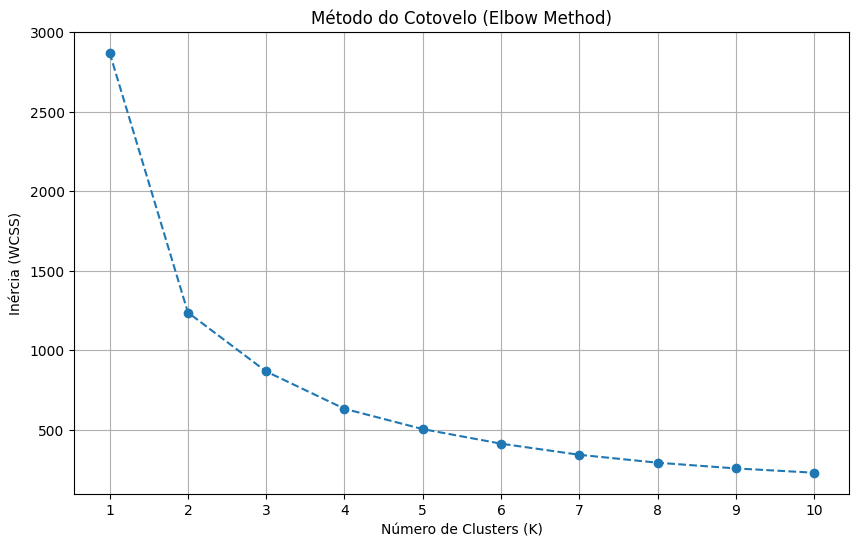

In [5]:
X = df[['latitude', 'longitude']]
inercia_list = []
k_intervalo = range(1, 11)
for k in k_intervalo:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(X)
  inercia_list.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(k_intervalo, inercia_list, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.xticks(k_intervalo)
plt.grid(True)
plt.show()

In [6]:
# entendendo matemáticamente a escolha da quantidade de cluestes/CDs 
df_cotovelo = pd.DataFrame({'k': k_intervalo, 
                            'inercia': inercia_list})
df_cotovelo['reducao_inercia'] = df_cotovelo['inercia'].diff().abs()
df_cotovelo['reducao_percentual'] = (
    df_cotovelo['reducao_inercia'] / df_cotovelo['inercia'].shift(1)
    ) * 100
df_cotovelo = df_cotovelo.fillna(0)
df_cotovelo.index = df_cotovelo.index + 1
formatters = {
    'inercia': '{:,.2f}'.format,
    'reducao_inercia': '{:,.2f}'.format,
    'reducao_percentual': '{:.2f}%'.format
}
display(df_cotovelo.apply(formatters))

,inercia,reducao_inercia,reducao_percentual
1,"2,870.18",0.00,0.00%
2,"1,236.28","1,633.90",56.93%
3,865.27,371.01,30.01%
4,630.75,234.51,27.10%
5,502.92,127.84,20.27%
6,411.29,91.63,18.22%
7,341.33,69.96,17.01%
8,291.53,49.80,14.59%
9,255.59,35.94,12.33%
10,228.55,27.04,10.58%


### Justificativa para 3 clusters

A escolha de 3 clusters foi definida com base na análise do método do cotovelo (Elbow Method).

- Observando a variação da inércia (coluna de reducao_percentual), nota-se que:
De k=1 para k=2 ocorre a maior redução (≈57%), o que é esperado ao dividir os dados em dois grupos.

- De k=2 para k=3 ainda há uma redução significativa (≈30%), indicando uma estrutura real de três agrupamentos.

- A partir de k=4, as reduções tornam-se marginais (<27%), mostrando que novos clusters trazem pouco ganho.

Assim, o ponto de inflexão (“cotovelo”) da curva ocorre em k=3, sendo este o número ideal de clusters, equilibrando simplicidade do modelo e qualidade do agrupamento.



Valor total das entregas por Centro de Distribuição (Cluster):


CD,valor_total_formatado
1,"R$ 13.631,26"
2,"R$ 14.735,93"
3,"R$ 12.816,62"


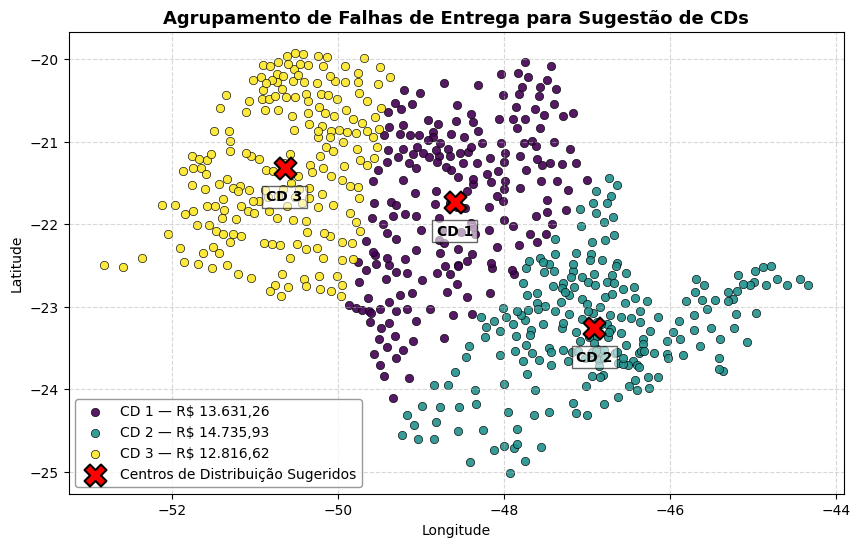

In [8]:
numero_de_clusters = 3
kmeans = KMeans(n_clusters=numero_de_clusters, 
                random_state=42, 
                n_init=10)
df['CD'] = kmeans.fit_predict(X)

# Agrupamento e soma por cluster
valor_por_cluster = (df.groupby('CD')['price'].sum())

valor_por_cluster.index = valor_por_cluster.index + 1

print("\nValor total das entregas por Centro de Distribuição (Cluster):")
df_valor_por_cluster = valor_por_cluster.reset_index()
df_valor_por_cluster.rename(columns={'price': 'valor_total', 'CD': 'CD'}, inplace=True)

# fiz old school rs -- Helder
df_valor_por_cluster['valor_total_formatado'] = df_valor_por_cluster['valor_total'].apply(
    lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
)

display(
    df_valor_por_cluster[['CD', 'valor_total_formatado']]
    .style.set_table_styles([{'selector': 'th, td', 'props': [('text-align', 'center')]}])
    .hide(axis='index')
)

# plot
plt.figure(figsize=(10, 6))
cmap = plt.cm.get_cmap('viridis', numero_de_clusters)

for c in sorted(df['CD'].unique()):
    subset = df[df['CD'] == c]
    
    # Pega o valor formatado para cada CD para colocar na legenda
    valor_legenda = df_valor_por_cluster.loc[df_valor_por_cluster['CD'] == c + 1, 'valor_total_formatado'].values[0]

    # Bolinhas para cada entrega com falha
    plt.scatter(
        subset['longitude'],
        subset['latitude'],
        c=[cmap(c)],
        label=f'CD {c + 1} — {valor_legenda}',
        marker='o',
        edgecolor='black',
        linewidths=0.5,
        alpha=0.9
    )

# Centros de distribuição com X
plt.scatter(
    kmeans.cluster_centers_[:, 1],
    kmeans.cluster_centers_[:, 0],
    s=250,
    c='red',
    edgecolor='black',
    linewidths=1.5,
    marker='X',
    label='Centros de Distribuição Sugeridos'
)

# Rótulos
for i, (lat, lon) in enumerate(kmeans.cluster_centers_):
    plt.text(
        lon, lat - 0.4,
        f'CD {i + 1}',
        fontsize=10,
        color='black',
        ha='center',
        fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3', alpha=0.6)
    )

plt.title('Agrupamento de Falhas de Entrega para Sugestão de CDs', fontsize=13, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(frameon=True, facecolor='white', edgecolor='gray', loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Justificativa da Escolha do Algoritmo:

- O algoritmo escolhido foi o **K-means**. A escolha se justifica porque o objetivo da atividade é agrupar geograficamente as falhas de entrega
para identificar locais centrais para novos centros de distribuição. O K-means é ideal para isso, pois
ele agrupa os dados minimizando a distância entre os pontos (nossas coordenadas de latitude e longitude)
e o centro do seu respectivo cluster (o futuro centro de distribuição).

- A análise pode ser considerada bem-sucedida, pois o algoritmo conseguiu separar claramente os pontos
em grupos distintos com base em sua proximidade geográfica, como pode ser visto no gráfico.
Cada cluster representa uma região densa de falhas que poderia ser eficientemente atendida por um
novo centro de distribuição, e o cálculo do valor total por cluster ajuda a dimensionar e priorizar
a importância de cada novo centro.

### Coordenadas do CDs

In [7]:
centros = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=['latitude', 'longitude']
)

centros.index = centros.index + 1
centros.index.name = 'CD'

centros['latitude'] = centros['latitude'].round(6)
centros['longitude'] = centros['longitude'].round(6)

print("Coordenadas dos Centros de Distribuição:")
display(centros)

Coordenadas dos Centros de Distribuição:


,latitude,longitude
CD,,
1,-21.731081,-48.590979
2,-23.263515,-46.910212
3,-21.316387,-50.641186
